In [1]:
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar

In [2]:
class SequenceModel(nn.Module):
    def __init__(self):
        super(SequenceModel, self).__init__()
        self.num_positions = 9
        self.num_embeddings = 1024
        self.embedding_dim = 6
        
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=self.num_embeddings, embedding_dim=self.embedding_dim) 
            for _ in range(self.num_positions)
        ])
        
        self.conv1 = nn.Conv1d(in_channels=54,  out_channels=72,  kernel_size=3, stride=3)
        self.conv2 = nn.Conv1d(in_channels=72,  out_channels=120, kernel_size=3, stride=3)
        
        self.fc1 = nn.Linear(120, 120)
        self.fc2 = nn.Linear(120, 24)
    
    def forward(self, x):
        batch_size = x.shape[0]
        embeddings = [self.embeddings[i](x[:, :, i]) for i in range(self.num_positions)]
        embeddings = torch.stack(embeddings, dim=3)
        reshaped = embeddings.view(batch_size, 54, -1)
        x = F.relu(self.conv1(reshaped))
        x = F.relu(self.conv2(x))
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
dataset = load_dataset("danjacobellis/audio_har_descript_44kHz_frames",split='train').with_format("torch",device="cuda")
dataloader = DataLoader(dataset, batch_size=16)
model = SequenceModel().to("cuda")
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

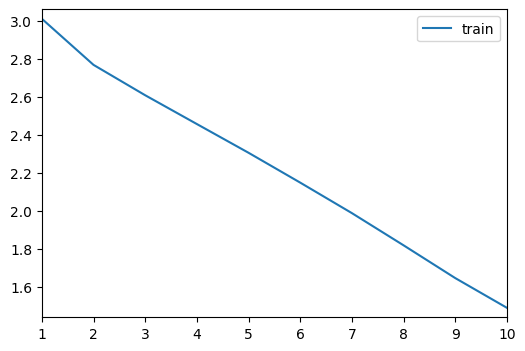

In [4]:
epochs = 10
mb = master_bar(range(1, epochs + 1))
train_loss = []

for epoch in mb:
    model.train()
    running_loss = 0.0
    for inputs in progress_bar(dataloader, parent=mb):
        codes = inputs['codes'].to(torch.int64)
        targets = inputs['label']
        one_hot_targets = F.one_hot(targets, num_classes=24).to(torch.float)

        optimizer.zero_grad()
        outputs = model(codes)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    train_loss.append(epoch_loss)

    mb.write(f'Epoch {epoch}: Train Loss: {epoch_loss:.4f}')
    
    graphs = [[range(1, epoch + 1), train_loss]]
    x_bounds = [1, epochs]
    y_bounds = [min(train_loss) - 0.05, max(train_loss) + 0.05]
    mb.update_graph(graphs, x_bounds, y_bounds)